<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Lab 4: Build a Convolution Neural Network

</div>


In [1]:
# Download dataset
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy

--2023-10-29 08:43:27--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy’

normal.npy          100%[===================>]  62.50M   266MB/s    in 0.2s    

2023-10-29 08:43:27 (266 MB/s) - ‘normal.npy’ saved [65536128/65536128]

--2023-10-29 08:43:27--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

## A. Data Loading and Preprocessing

In Convolutional Neural Networks (CNNs), the convolution operation expects the input to have a specific shape, typically denoted as `[batch_size, channels, height, width]`. The "channels" dimension refers to the number of input channels (or depth) of the input data.

For standard RGB images, this channels value is 3 (for red, green, and blue). For grayscale images, there's only one channel. For more specialized data, there could be more channels. For example, medical imaging modalities like MRI or CT can sometimes have multiple channels representing different types of scans or different views of the same scan.

When working with data that doesn't naturally have a channels dimension (e.g., plain grayscale image arrays that are just `[height, width]`), you need to explicitly add a channels dimension to match the expected input format of the CNN. This is done using `.unsqueeze(1)` which adds an additional dimension at the 1st position (0-indexed), converting a shape like `[batch_size, height, width]` to `[batch_size, 1, height, width]`. The "1" here indicates a single channel.


In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float().unsqueeze(1)
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float().unsqueeze(1)
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


## B. Defining Neural Networks

### 1. Use the **Class**

In PyTorch, we define our custom neural network architectures by subclassing the `nn.Module` class. This gives our neural network all the functionality it needs to work with PyTorch's other utilities and keeps our implementation organized.

- Neural networks are defined by subclassing `nn.Module`.
- The layers of the neural network are initialized in the `__init__` method.
- The forward pass operations on input data are defined in the `forward` method.

It's worth noting that while we only define the forward pass, PyTorch will automatically derive the backward pass for us, which is used during training to update the model's weights."

In [36]:
import torch.nn as nn
import torch.nn.functional as F

# model = nn.Sequential(
#     nn.Flatten(),
#     nn.Linear(256*256*1, 32), # 1st FC
#     nn.ReLU(),
#     nn.Linear(32, 32),        # 2nd FC
#     nn.ReLU(),
#     nn.Linear(32, 32),        # 3rd FC
#     nn.ReLU(),
#     nn.Linear(32, 1)          # 4th FC
# ).cuda()

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256*256*1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

### 2. ann2cnn

To transition a model from an ANN to a CNN using `nn.Conv2d` layers, we make the following changes:

- Replace `nn.Linear` layers with `nn.Conv2d` layers for the initial layers.
- Add pooling layers after convolutional layers for spatial dimension reduction.
- Introduce a flattening step before transitioning to fully connected layers.
- Adjust the `forward` method to handle the convolutional and pooling operations and reshaping.

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class ConvModel(nn.Module): #with Drop out
    def __init__(self, dropout_prob=0.0): # default dropout_prob is 0.0 which means no dropout
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) # I've changed padding='same' to padding=1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        flattened_dim = 32 * 32 * 32

        self.fc1 = nn.Linear(flattened_dim, 32)
        self.dropout = nn.Dropout(dropout_prob) # Adding dropout layer
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = x.reshape(x.size(0), -1)  # x.size(0) is the batch size

        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Apply dropout here
        return self.fc2(x)


In [49]:
import torch.nn as nn
import torch.nn.functional as F


class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()

        # 1 channel, and using 3x3 kernels for simplicity, 256*256
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128*128

        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 128*128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64*64

        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same') # 64*64
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32*32

        # Adjust flattened dimensions based on the output size of your last pooling layer
        flattened_dim = 32 * 32 * 32

        self.fc1 = nn.Linear(flattened_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        # Flatten the output for the fully connected layers
        x = x.reshape(x.size(0), -1)  # x.size(0) is the batch size

        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [60]:
class ConvGAP(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding='same') ,
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128*128
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same'), # 128*128
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64*64
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same'), # 64*64
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32*32

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(32, 1)
        )

    def forward(self, x):

        x = self.net(x)
        return x

In [3]:
import torch.nn as nn #Increase Performance GAP

class ConvGAP(nn.Module):
    def __init__(self):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.5), # added dropout for regularization
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.net(x)
        return x


## C. Training the Neural Network

`model = model.cuda()` moves the model's parameters and buffers to the GPU memory.

In [4]:
import torch.optim as optim
import time
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 30

# Change you model here
model = ConvGAP()
#model = ConvModel()
print(model)
model = model.cuda()

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in tqdm(range(epochs)):
    start_time = time.time()  # Start time
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        images = images / 255.
        labels = labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)

        labels = labels.float().unsqueeze(1)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        train_predicted = torch.sigmoid(outputs) > 0.5
        train_correct += (train_predicted.float() == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.cuda()
            images = images / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.float().unsqueeze(1)

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'model_classification.pth')

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.2f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.2f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

end_time = time.time()  # End time
epoch_time = end_time - start_time  # Calculate the difference
print(f"Epoch {epoch+1}/{epochs} - Time taken: {epoch_time:.2f} seconds")

ConvGAP(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): AdaptiveAvgPool2d(output_size=1)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=256, out_features=1, bi

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30, Train loss: 0.3730, Train acc: 86.69%, Val loss: 2.7954, Val acc: 50.00%, Best Val loss: 2.7954 Best Val acc: 50.00%
Epoch 2/30, Train loss: 0.2961, Train acc: 89.00%, Val loss: 2.4333, Val acc: 50.00%, Best Val loss: 2.4333 Best Val acc: 50.00%
Epoch 3/30, Train loss: 0.2690, Train acc: 89.88%, Val loss: 0.2735, Val acc: 88.25%, Best Val loss: 0.2735 Best Val acc: 88.25%
Epoch 4/30, Train loss: 0.2353, Train acc: 91.81%, Val loss: 0.2248, Val acc: 91.25%, Best Val loss: 0.2248 Best Val acc: 91.25%
Epoch 5/30, Train loss: 0.2365, Train acc: 91.50%, Val loss: 2.6519, Val acc: 51.50%, Best Val loss: 0.2248 Best Val acc: 91.25%
Epoch 6/30, Train loss: 0.2299, Train acc: 91.94%, Val loss: 0.8580, Val acc: 59.75%, Best Val loss: 0.2248 Best Val acc: 91.25%
Epoch 7/30, Train loss: 0.2174, Train acc: 92.75%, Val loss: 0.5406, Val acc: 79.25%, Best Val loss: 0.2248 Best Val acc: 91.25%
Epoch 8/30, Train loss: 0.2096, Train acc: 91.94%, Val loss: 0.9823, Val acc: 54.25%, Best Val lo

### Visualizing model performance

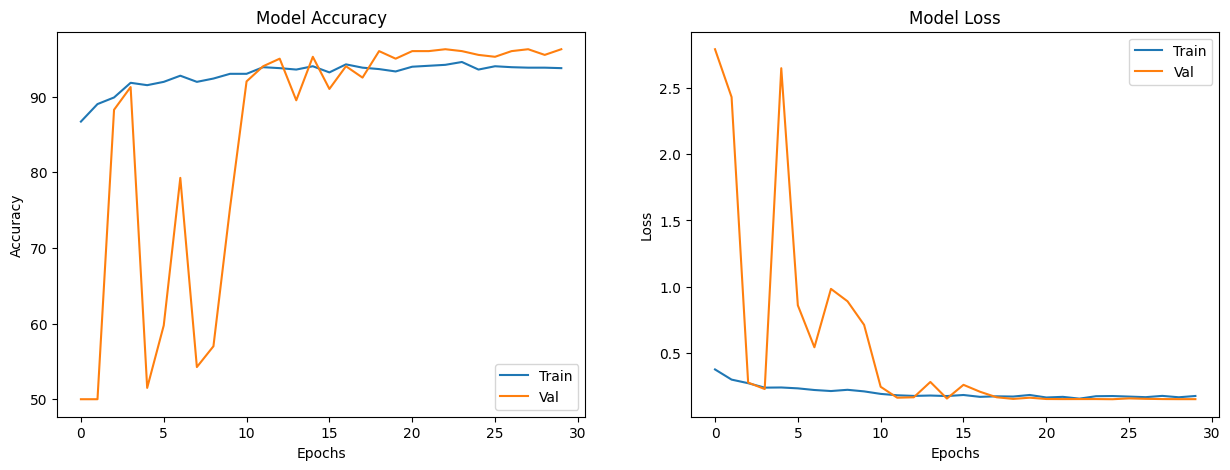

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [6]:
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy

--2023-10-29 08:50:53--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13107328 (12M) [application/octet-stream]
Saving to: ‘test_normal.npy’

test_normal.npy     100%[===================>]  12.50M  --.-KB/s    in 0.1s    

2023-10-29 08:50:53 (116 MB/s) - ‘test_normal.npy’ saved [13107328/13107328]

--2023-10-29 08:50:53--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/test/test_pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting respons

### Process Test Dataset

In [7]:
test_abnormal = np.load('test_pneumonia.npy')
test_normal = np.load('test_normal.npy')

print(f'Shape of test_abnormal: {test_abnormal.shape}')
print(f'Shape of test_normal: {test_normal.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.
test_abnormal_labels = np.ones((test_abnormal.shape[0],))
test_normal_labels = np.zeros((test_normal.shape[0],))

x_test = np.concatenate((test_abnormal, test_normal), axis=0)
y_test = np.concatenate((test_abnormal_labels, test_normal_labels), axis=0)

print(f'Shape of x_test: {x_test.shape}')
print(f'Shape of y_test: {y_test.shape}')


# Convert to PyTorch tensors
x_test = torch.from_numpy(x_test).float().unsqueeze(1)
y_test = torch.from_numpy(y_test).long()

# Combine the images and labels into a dataset
test_dataset = TensorDataset(x_test, y_test)

# Create a dataloader to load data in batches. Set batch size to 32.
test_loader = DataLoader(test_dataset, 32, shuffle=False)

Shape of test_abnormal: (200, 256, 256)
Shape of test_normal: (200, 256, 256)
Shape of x_test: (400, 256, 256)
Shape of y_test: (400,)


### Load Trained Model and Evaluate

In [8]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:

        images = images.cuda()
        images = images / 255.

        labels = labels.cuda()

        outputs = model(images)

        labels_float = labels.float().unsqueeze(1)  # Convert labels to float and match shape with outputs
        predicted = torch.sigmoid(outputs) > 0.5

        test_correct += (predicted.float() == labels_float).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

Test accuracy is 79.25%


In [54]:
# Ensure GPU is available
assert torch.cuda.is_available()

# Install necessary packages (only if not done already)
#!pip install torchsummary

from torchsummary import summary

# Load trained model (saved the best model as 'model_classification.pth')
model = ConvModel() # or LinearModel() ConvModel
model.load_state_dict(torch.load('model_classification.pth'))
model = model.cuda()

# Print model summary
print("ConvModel Architecture:")
summary(model, input_size=(1, 256, 256))

# Testing function
def test_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.cuda() / 255.
            labels = labels.cuda()
            outputs = model(images)

            predicted = torch.sigmoid(outputs) > 0.5
            correct += (predicted.float() == labels.float().unsqueeze(1)).sum().item()
            total += labels.size(0)

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Test the model
test_model(model, test_loader)


ConvModel Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
         MaxPool2d-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 32, 128, 128]           9,248
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           9,248
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Linear-7                   [-1, 32]       1,048,608
            Linear-8                    [-1, 1]              33
Total params: 1,067,457
Trainable params: 1,067,457
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 26.25
Params size (MB): 4.07
Estimated Total Size (MB): 30.57
----------------------------------------------------------------
Test Accurac